In [30]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats
import h5py
import statistics
import math
from scipy.optimize import curve_fit
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (12,7.5)
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## Lab 4: Working with 'real' data
### Introduction
In this lab we are going to work on how to estimate the background from 'real' data. Real is in air quotes because the data is actually from simplified simulations to make the problems manageable in a single lab. But the data will have some features that resemble that of real data sets.

### Getting data and HD5
In general exchanging raw data is a pain. Writing data in text files is error prone, inaccurate, and wastes space, but raw binary files have all sorts of subtleties too (including the internal byte order of your processor). To try and sidestep a whole set of nasty issues, we are going to use HDF5 (originally developed by the National Center for Supercomputing Applications for data exchange) to allow everyone to import the data.

In [32]:
# import for Problem 1:
hf = h5py.File('gammaray_lab4.h5', 'r')
print(hf.keys())
data = np.array(hf.get('data'))
print(data)
print("First row: ")
print(data[0, :])

<KeysViewHDF5 ['data']>
[[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
  9.43272016e+08 9.43272016e+08]
 [3.15000000e+02 3.15007112e+02 3.15014225e+02 ... 3.45319109e+02
  3.45326221e+02 3.45333333e+02]
 [4.50000000e+01 4.50066667e+01 4.50133333e+01 ... 4.49866667e+01
  4.49933333e+01 4.50000000e+01]
 [1.00000000e+01 8.00000000e+00 7.00000000e+00 ... 8.00000000e+00
  1.10000000e+01 1.20000000e+01]]
First row: 
[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
 9.43272016e+08 9.43272016e+08]


### Problem 1
In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

As with most data, there are 'features.' Your lab instructor has helpfully incorporated the meta-data into your data file.

#### 1) 
Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 rows and more than 25 million columns. The rows are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

In [4]:
# parse data into separate lists
time = data[0, :]
solar_phase = data[1, :]
earth_deg = data[2, :]
part_counts = data[3, :]

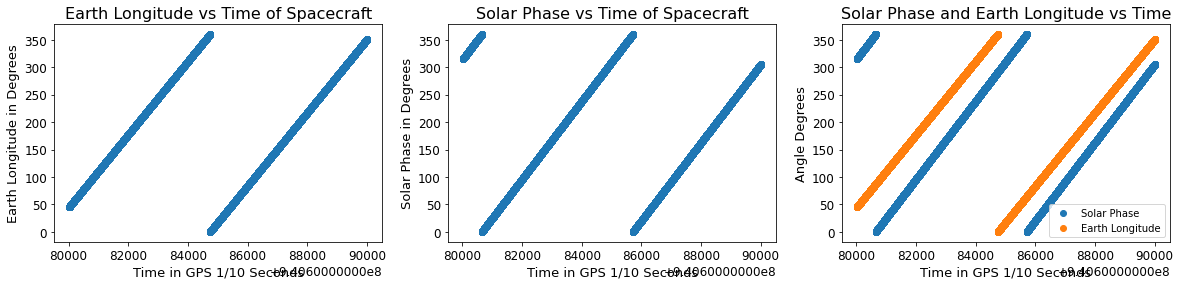

In [5]:
# plot various data to see data features
fig, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].scatter(time[:int(1e5)], earth_deg[:int(1e5)])
ax[0].set_title("Earth Longitude vs Time of Spacecraft", fontsize=16)
ax[0].set_xlabel("Time in GPS 1/10 Seconds", fontsize=13)
ax[0].set_ylabel("Earth Longitude in Degrees", fontsize=13)

ax[1].scatter(time[:int(1e5)], solar_phase[:int(1e5)])
ax[1].set_title("Solar Phase vs Time of Spacecraft", fontsize=16)
ax[1].set_xlabel("Time in GPS 1/10 Seconds", fontsize=13)
ax[1].set_ylabel("Solar Phase in Degrees", fontsize=13)

ax[2].scatter(time[:int(1e5)], solar_phase[:int(1e5)], label="Solar Phase")
ax[2].scatter(time[:int(1e5)], earth_deg[:int(1e5)], label="Earth Longitude")
ax[2].set_title("Solar Phase and Earth Longitude vs Time", fontsize=16)
ax[2].set_xlabel("Time in GPS 1/10 Seconds", fontsize=13)
ax[2].set_ylabel("Angle Degrees", fontsize=13)
ax[2].legend()

Text(0, 0.5, 'Cosmic Ray Counts')

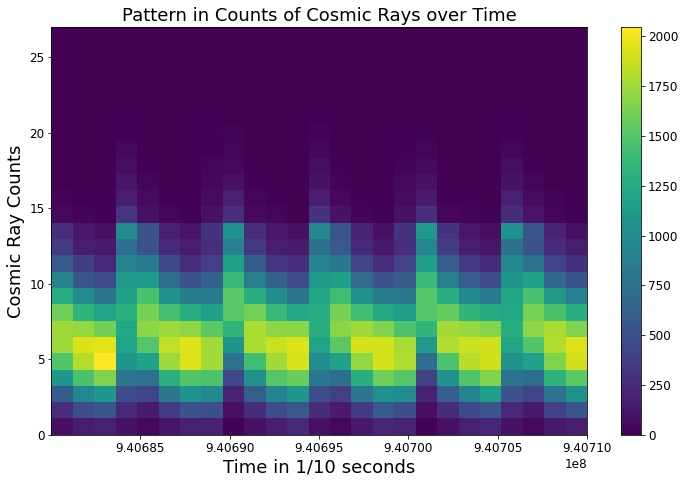

In [37]:
plt.hist2d(time[:300000], part_counts[:300000], bins=25)
plt.colorbar()
plt.title("Pattern in Counts of Cosmic Rays over Time", fontsize=18)
plt.xlabel("Time in 1/10 seconds", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

Text(0, 0.5, 'Cosmic Ray Counts')

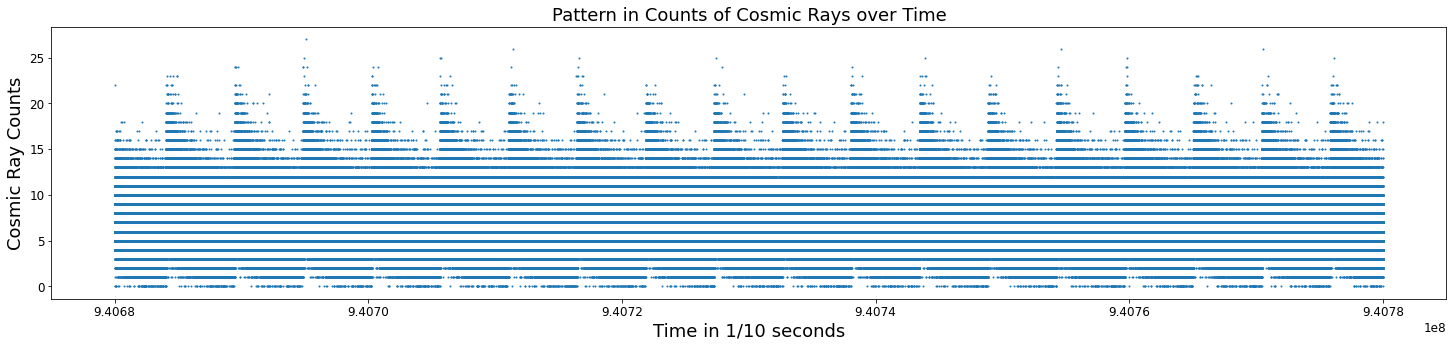

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.scatter(time[:int(1e6)], part_counts[:int(1e6)], s=1)
plt.title("Pattern in Counts of Cosmic Rays over Time", fontsize=18)
plt.xlabel("Time in 1/10 seconds", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

#### 1)
As we can see from the graphs of Earth Longitude vs. Time, the spacecraft does make a full revolution around the Earth approximately every 90 minutes. Also, the solar phase and earth longitude don't appear to be have the same period since they're offset by an non-constant amount. From the above graphs of Cosmic Rays vs. Time, we can see that the number of cosmic rays fluctuates based on the time in the cycle. The non-constant background can contaminate any signal that we see. We can build a background pdf by folding the data to one cycle, and then finding the distribution of the data at different points in time in the cycle.

#### 2) 
The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

Text(0, 0.5, 'Cosmic Ray Counts')

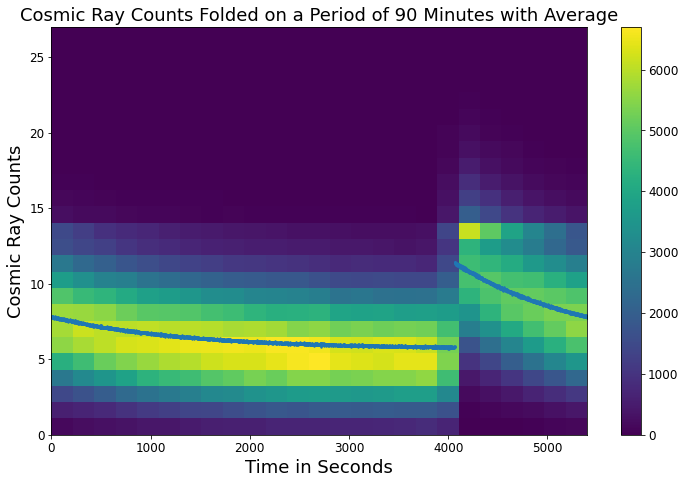

In [38]:
# fold time to 90 minute cycle (5400 seconds)
t_cycle = time % 5400
plt.hist2d(t_cycle[:int(1e6)], part_counts[:int(1e6)], bins=25)
plt.colorbar()
binned_stat = stats.binned_statistic(x=t_cycle, values=part_counts, statistic="mean", bins=5400)
plt.scatter(range(0,5400), binned_stat.statistic, s=2)
plt.title("Cosmic Ray Counts Folded on a Period of 90 Minutes with Average", fontsize=18)
plt.xlabel("Time in Seconds", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

Text(0, 0.5, 'Cosmic Ray Counts')

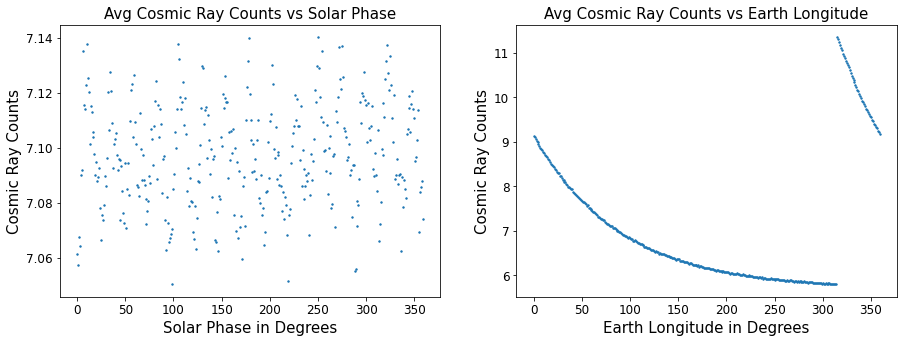

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

binned_stat = stats.binned_statistic(x=solar_phase, values=part_counts, statistic="mean", bins=360)
ax[0].scatter(range(0,360), binned_stat.statistic, s=2)
ax[0].set_title("Avg Cosmic Ray Counts vs Solar Phase", fontsize=15)
ax[0].set_xlabel("Solar Phase in Degrees", fontsize=15)
ax[0].set_ylabel("Cosmic Ray Counts", fontsize=15)

binned_stat = stats.binned_statistic(x=earth_deg, values=part_counts, statistic="mean", bins=360)
ax[1].scatter(range(0,360), binned_stat.statistic, s=2)
ax[1].set_title("Avg Cosmic Ray Counts vs Earth Longitude", fontsize=15)
ax[1].set_xlabel("Earth Longitude in Degrees", fontsize=15)
ax[1].set_ylabel("Cosmic Ray Counts", fontsize=15)

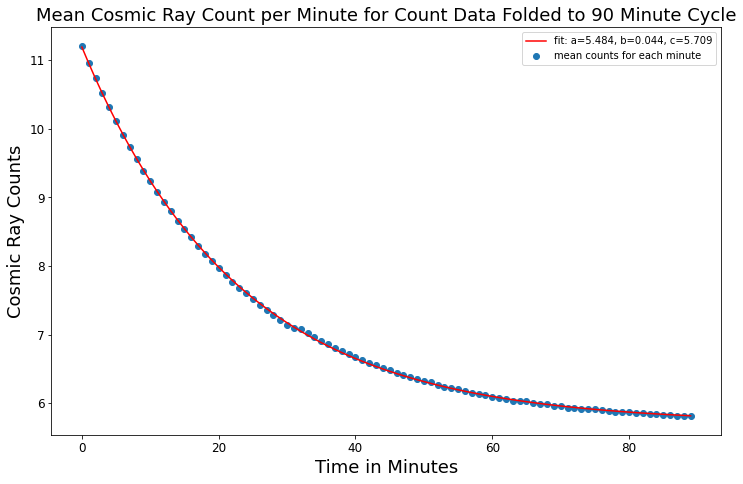

In [31]:
# bin all data per minute after folding time to 90 minute cycle
binned_stat = stats.binned_statistic(x=t_cycle, values=part_counts, statistic="mean", bins=90)
means = binned_stat.statistic
# sort by descending since data doesn't start at beginning of cycle for distribution
sorted_means_desc = np.sort(means)[::-1]
xdata = range(0, 90)

fig, ax = plt.subplots(1, 1)
ax.scatter(xdata, sorted_means_desc, label="mean counts for each minute")
plt.title("Mean Cosmic Ray Count per Minute for Count Data Folded to 90 Minute Cycle", fontsize=18)
plt.xlabel("Time in Minutes", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

# code borrowed from the scipy.optimize.curve_fit documentation
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, xdata, sorted_means_desc)
ax.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
ax.legend()

#### 2)
In each 90 minute cycle, the counts start high and decreases exponentially. We find this by folding the data to the 90 minute cycle and the taking the mean of all the data within each minute of the folded data, then plotting and curve-fitting these means. On average, the background data follows the function: 5.484 * e^(0.044x) + 5.709 over each 90 minute cycle.

#### 3) 
Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

Mean Count for Minute 1 in the Cycle= 11.14646875, mu=11
Mean Count for Minute 41 in the Cycle= 6.620751565762004, mu=7
Mean Count for Minute 89 in the Cycle= 5.8065309672929715, mu=6


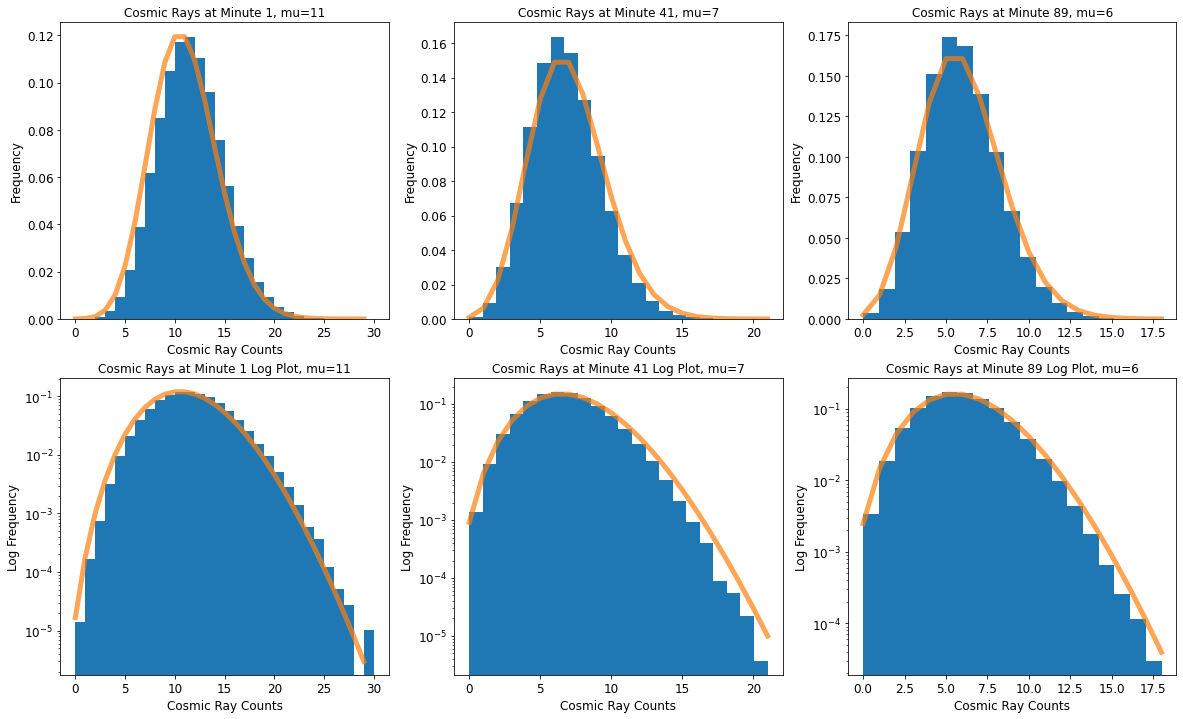

In [14]:
# from plotting the above graph without sorting, we find that the cycle starts at the 68th minute out of 90
# cut off <1 cycle in front so data starts at beginning of time cycle
i = 40800
time_cycle = t_cycle[i:]
# adjust count data accordingly
counts_new = part_counts[i:]

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

# plots distribution of cosmic rays at a certain minute in the 90 minute cycle - data folded to 90 minutes
# minute: the minute out of 90
# time_data: folded time data
# count_data: cosmic ray count data
# num_bins: number of bins used to display the count data
# plot_row: row in the subplot grid
# plot_col: col in the subplot grid
# yscale_log: plots data for this minute on a log plot if yscale_log='log'
def plot_minute_dist(minute, time_data, count_data, num_bins, plot_row, plot_col, yscale_log):
    minute_data = []
    for i in range((minute-1)*600, len(time_data), 54000):
        minute_data.extend(count_data[i:i+600])
    ax[plot_row, plot_col].hist(minute_data, bins=num_bins, density=True)
    mean = statistics.mean(minute_data)
    mu = math.ceil(mean) if mean % 1 > 0.5 else math.floor(mean) # round up or down
    x = np.arange(0, num_bins)
    ax[plot_row, plot_col].plot(x, stats.poisson.pmf(x, mu), linewidth = 5, alpha = 0.7)
    ax[plot_row, plot_col].set_xlabel('Cosmic Ray Counts', fontsize=12)
    if yscale_log == 'log':
        print("Mean Count for Minute " + str(minute) + " in the Cycle= " + str(mean) + ", mu=" + str(mu))
        ax[plot_row, plot_col].set_yscale('log')
        ax[plot_row, plot_col].set_title('Cosmic Rays at Minute ' + str(minute) + " Log Plot, mu=" + str(mu), fontsize=12)
        ax[plot_row, plot_col].set_ylabel('Log Frequency', fontsize=12)
    else:
        ax[plot_row, plot_col].set_title('Cosmic Rays at Minute ' + str(minute) + ", mu=" + str(mu), fontsize=12)
        ax[plot_row, plot_col].set_ylabel('Frequency', fontsize=12)

plot_minute_dist(1, time_cycle, counts_new, 30, 0, 0, '')
plot_minute_dist(41, time_cycle, counts_new, 22, 0, 1, '')
plot_minute_dist(89, time_cycle, counts_new, 19, 0, 2, '')
plot_minute_dist(1, time_cycle, counts_new, 30, 1, 0, 'log')
plot_minute_dist(41, time_cycle, counts_new, 22, 1, 1, 'log')
plot_minute_dist(89, time_cycle, counts_new, 19, 1, 2, 'log')

#### 3)
